In [11]:
import pandas as pd
import numpy as np

# Load dataset
column_names = [
    "age", "sex", "cp", "trestbps", "chol", "fbs", "restecg",
    "thalach", "exang", "oldpeak", "slope", "ca", "thal", "target"
]

df = pd.read_csv("cleveland.csv", names=column_names)
df.replace('?', np.nan, inplace=True)
df = df.apply(pd.to_numeric, errors='coerce')
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df.head

<bound method NDFrame.head of       age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0    63.0  1.0  1.0     145.0  233.0  1.0      2.0    150.0    0.0      2.3   
1    67.0  1.0  4.0     160.0  286.0  0.0      2.0    108.0    1.0      1.5   
2    67.0  1.0  4.0     120.0  229.0  0.0      2.0    129.0    1.0      2.6   
3    37.0  1.0  3.0     130.0  250.0  0.0      0.0    187.0    0.0      3.5   
4    41.0  0.0  2.0     130.0  204.0  0.0      2.0    172.0    0.0      1.4   
..    ...  ...  ...       ...    ...  ...      ...      ...    ...      ...   
292  57.0  0.0  4.0     140.0  241.0  0.0      0.0    123.0    1.0      0.2   
293  45.0  1.0  1.0     110.0  264.0  0.0      0.0    132.0    0.0      1.2   
294  68.0  1.0  4.0     144.0  193.0  1.0      0.0    141.0    0.0      3.4   
295  57.0  1.0  4.0     130.0  131.0  0.0      0.0    115.0    1.0      1.2   
296  57.0  0.0  2.0     130.0  236.0  0.0      2.0    174.0    0.0      0.0   

     slope   ca  thal

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE

# Features and target
X = df.drop("target", axis=1)
y = df["target"].astype(int)

# Define categorical and numerical features
categorical = ["sex", "cp", "fbs", "restecg", "exang", "slope", "ca", "thal"]
numerical = ["age", "trestbps", "chol", "thalach", "oldpeak"]

# Preprocessor pipeline
preprocessor = ColumnTransformer(transformers=[
    ("num", StandardScaler(), numerical),
    ("cat", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), categorical)
])

# Apply preprocessing
X_processed = preprocessor.fit_transform(X)

# Feature selection (optional but improves model speed)
selector = SelectKBest(score_func=f_classif, k="all")
X_selected = selector.fit_transform(X_processed, y)


In [3]:
from collections import Counter

print("Before SMOTE:", Counter(y))
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_selected, y)
print("After SMOTE:", Counter(y_resampled))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42
)

# Final scale for deep learning
scaler_final = StandardScaler()
X_train_scaled = scaler_final.fit_transform(X_train)
X_test_scaled = scaler_final.transform(X_test)


Before SMOTE: Counter({0: 160, 1: 54, 2: 35, 3: 35, 4: 13})
After SMOTE: Counter({0: 160, 2: 160, 1: 160, 3: 160, 4: 160})


In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model = Sequential([
    Dense(256, activation="relu", input_shape=(X_train_scaled.shape[1],)),
    LayerNormalization(),
    Dropout(0.3),

    Dense(128, activation="relu"),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation="relu"),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation="relu"),
    BatchNormalization(),
    Dropout(0.2),

    Dense(5, activation="softmax")  # 5-class output
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0003)
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

early_stopping = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-5)

# Training
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=300,
    batch_size=128,
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)
train_loss, train_acc = model.evaluate(X_train_scaled, y_train, verbose=0)
test_loss, test_acc = model.evaluate(X_test_scaled, y_test, verbose=0)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


Epoch 1/300


c:\Users\haris\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.2477 - loss: 2.1712 - val_accuracy: 0.2250 - val_loss: 1.7383 - learning_rate: 3.0000e-04
Epoch 2/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.2390 - loss: 2.1532 - val_accuracy: 0.2625 - val_loss: 1.6616 - learning_rate: 3.0000e-04
Epoch 3/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.2920 - loss: 1.9026 - val_accuracy: 0.2688 - val_loss: 1.5901 - learning_rate: 3.0000e-04
Epoch 4/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.2727 - loss: 1.8214 - val_accuracy: 0.3125 - val_loss: 1.5235 - learning_rate: 3.0000e-04
Epoch 5/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3351 - loss: 1.6795 - val_accuracy: 0.3375 - val_loss: 1.4595 - learning_rate: 3.0000e-04
Epoch 6/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3122 - loss: 1.6757 - val_accuracy: 0.3938 - val_loss: 1.3968 - learning_rate: 3.0000e-04
Epoch 7/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3872 - loss: 1.5056 - v

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
              precision    recall  f1-score   support

           0       0.93      0.78      0.85        32
           1       0.80      0.88      0.84        32
           2       0.91      0.97      0.94        32
           3       0.97      0.94      0.95        32
           4       0.97      1.00      0.98        32

    accuracy                           0.91       160
   macro avg       0.92      0.91      0.91       160
weighted avg       0.92      0.91      0.91       160

Accuracy: 0.9125


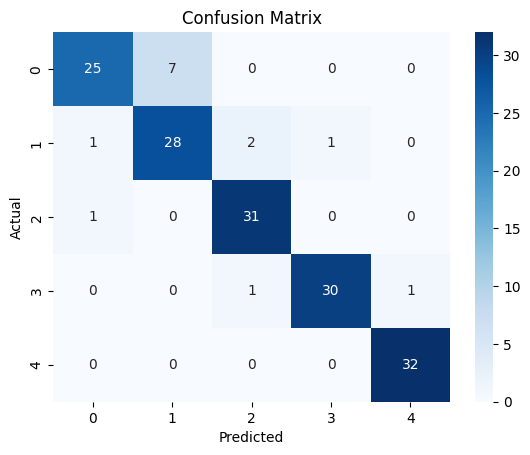

In [13]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_test_scaled).argmax(axis=1)

print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [6]:
# Save Model
model.save("heart_severity_model.keras")

# Save Pipelines
import joblib
joblib.dump(preprocessor, "heart_preprocessor.pkl")
joblib.dump(selector, "heart_feature_selector.pkl")
joblib.dump(scaler_final, "heart_final_scaler.pkl")


['heart_final_scaler.pkl']

In [8]:
import matplotlib.pyplot as plt

# Accuracy Plot
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('accuracy_curve.png')
plt.close()

# Loss Plot
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('loss_curve.png')
plt.close()


In [9]:
from sklearn.metrics import classification_report
import seaborn as sns
import numpy as np

report_dict = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

plt.figure(figsize=(10, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap='Blues', fmt=".2f")
plt.title('Classification Report Heatmap')
plt.savefig('classification_report_heatmap.png')
plt.close()


In [10]:
lr_schedule = history.history.get("learning_rate") or []

if lr_schedule:
    plt.figure(figsize=(8, 4))
    plt.plot(lr_schedule)
    plt.title("Learning Rate Schedule")
    plt.xlabel("Epoch")
    plt.ylabel("Learning Rate")
    plt.grid(True)
    plt.savefig("lr_schedule.png")
    plt.close()
